# Fundamental of ML Final Project: Handwritten Image Classifier

### Library imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow.keras as keras
import cv2
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
import time

### Unused Functions

In [947]:
def vert_det(im, kernel):
    vert = cv2.Sobel(im, ddepth=cv2.CV_64F, dx=0, dy=1, ksize=kernel)
    return im-vert

def hor_det(im, kernel):
    hor = cv2.Sobel(im, ddepth=cv2.CV_64F, dx=1, dy=0, ksize=kernel)
    return im-hor

def binarize(im):
    threshold = np.max(im)-.6
    im[im < threshold] = 0
    im[im >= threshold] = 1
    return im

def otsu(im):
    im = im.astype("uint8")
    _, r = cv2.threshold(im, 0, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)
    return r

def bounding_box_transform(im):
    tt = np.argmax(im, axis=0)
    leftbound = np.amin(np.nonzero(tt))
    rightbound = np.amax(np.nonzero(tt))
    t = np.argmax(im, axis=1)
    upbound = np.amin(np.nonzero(t))
    downbound = np.amax(np.nonzero(t))
    boundarybox = np.float32([[leftbound-10,upbound-10],[rightbound+10,upbound-10]
                              ,[leftbound-10,downbound+10],[rightbound+10,downbound+10]])
    newbox = np.float32([[0,0],[300,0],[0,300],[300,300]])
    M = cv2.getPerspectiveTransform(boundarybox,newbox)
    dst = cv2.warpPerspective(im,M,(300,300))
    return dst

# takes in a non-inverted image (non min max normalized)
def remove_lines(z):
    z = z.reshape(300,300)
    z = update_type(z)
    
    #threshold the image
    thresh = cv2.threshold(z, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)[1]

    # Remove horizontal
    horizontal_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (50,1))
    detected_lines = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, horizontal_kernel, iterations=1)
    cnts = cv2.findContours(detected_lines, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = cnts[0] if len(cnts) == 2 else cnts[1]
    for c in cnts:
        cv2.drawContours(z, [c], -1, (255,255,255), 2)

    # Repair image
    repair_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (1,6))
    result = 255 - cv2.morphologyEx(255 - z, cv2.MORPH_CLOSE, repair_kernel, iterations=2)
    
    #threshold the image
    thresh = cv2.threshold(result, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)[1]

    # Remove vertical
    vertical_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (1,50))
    detected_lines = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, vertical_kernel, iterations=1)
    cnts = cv2.findContours(detected_lines, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = cnts[0] if len(cnts) == 2 else cnts[1]
    for c in cnts:
        cv2.drawContours(result, [c], -1, (255,255,255), 2)

    # Repair image
    repair_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (6,1))
    result = 255 - cv2.morphologyEx(255 - result, cv2.MORPH_CLOSE, repair_kernel, iterations=2)
    
    return result

### Used Functions

In [948]:
def show(im):
    plt.imshow(im, cmap='gray')
    plt.show()

def invert(im):
    return (im*-1)+255

def min_max_scale(im):
    im = MinMaxScaler().fit_transform(im.ravel().reshape(-1,1))
    return im.reshape(300,300)

def brighten(im):
    m = np.max(im)-.3
    im[im >= m] += 0.3
    im[im < m] -= 0.3
    return im

def blur(im, kernel):
    im = im.astype("uint8")
    im = cv2.medianBlur(im, kernel)
    return im

def morph_close(im, kernel, i):
    return cv2.morphologyEx(im, cv2.MORPH_CLOSE, kernel, iterations=i)

def morph_open(im, kernel, i):
    return cv2.morphologyEx(im, cv2.MORPH_OPEN, kernel, iterations=i)

def morph_dilate(im, kernel, i):
    return cv2.dilate(im, kernel, iterations=i)

def morph_erode(im, kernel, i):
    return cv2.erode(im, kernel, iterations=i)

def transform(im):
    dest = np.float32([[0,0],[300,0],[0,300],[300,300]])
    source = np.float32([[25,25],[275,25],[25,275],[275,275]])
    res = cv2.getPerspectiveTransform(source,dest)
    return cv2.warpPerspective(im, res, (300,300))

In [991]:
def preprocess(ims):
    r = []
    for im in ims.T:
        im = im.reshape((300,300))
        im = transform(im)
        im = invert(im)
        im = blur(im, 5)
        im = morph_erode(im, (3,3), 5)
        im = morph_dilate(im, (3,3), 5)
        im = morph_close(im, (3,3), 5)
        im = morph_open(im, (3,3), 5)
        im = min_max_scale(im)
        im = brighten(im)
        im = min_max_scale(im)
        im = cv2.resize(im, (100,100))
        im = np.stack((im,)*3, axis=-1)
        r.append(im)
    return np.array(r)

def augment(ims, labels):
    result = []
    n = []
    o = []
    t = []
    for im in ims:
        im = cv2.rotate(im, cv2.cv2.ROTATE_90_CLOCKWISE)
        n.append(im)
        im = cv2.rotate(im, cv2.cv2.ROTATE_90_CLOCKWISE)
        o.append(im)
        im = cv2.rotate(im, cv2.cv2.ROTATE_90_CLOCKWISE)
        t.append(im)
    result.append(ims)
    result.append(n)
    result.append(o)
    result.append(t)
    labels_new = np.concatenate((labels,labels,labels,labels))
    return np.array(result).reshape(-1,100,100), labels_new

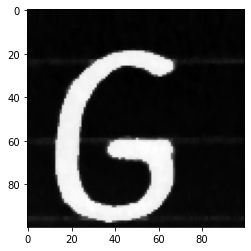

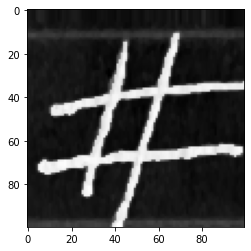

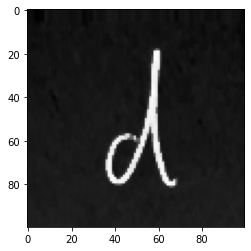

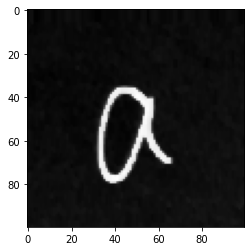

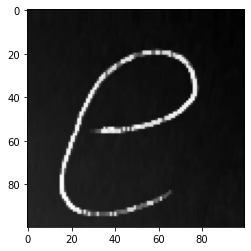

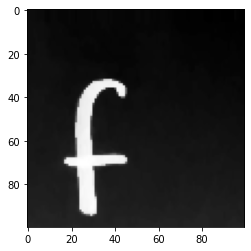

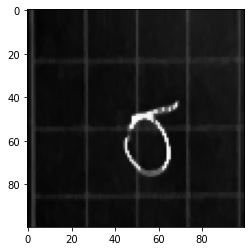

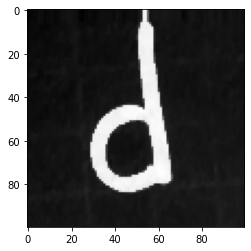

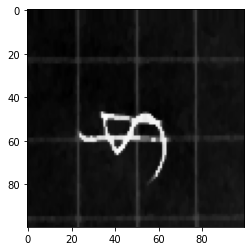

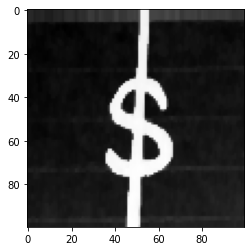

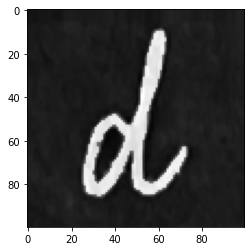

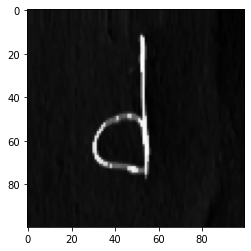

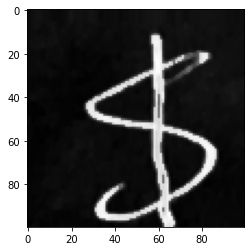

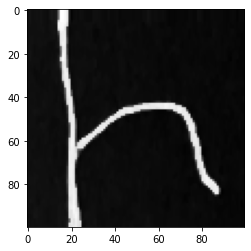

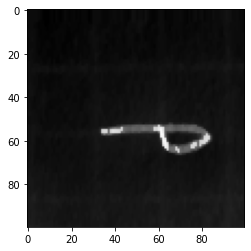

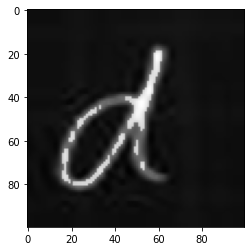

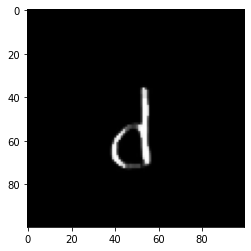

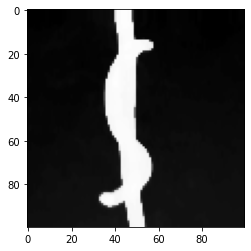

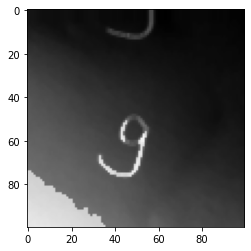

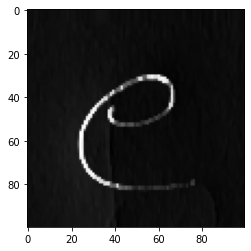

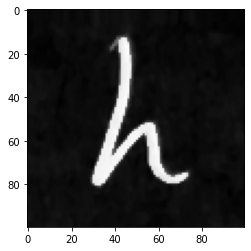

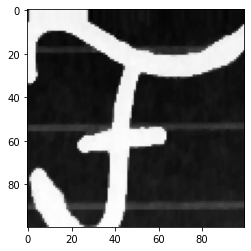

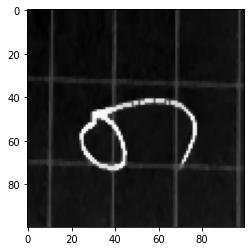

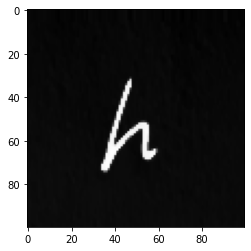

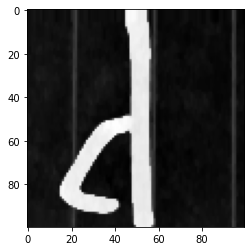

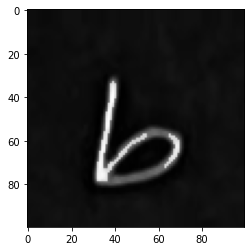

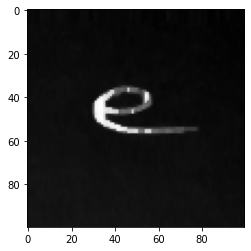

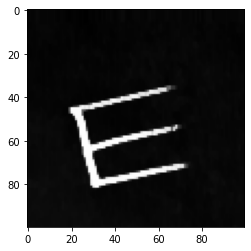

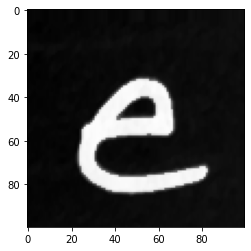

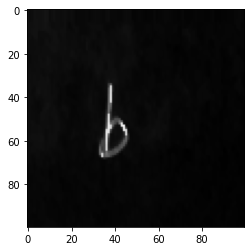

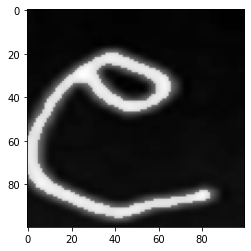

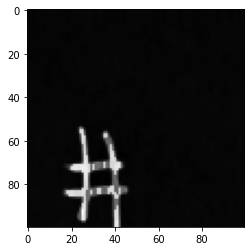

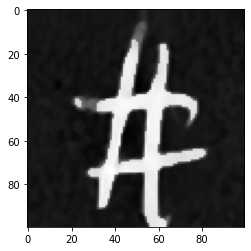

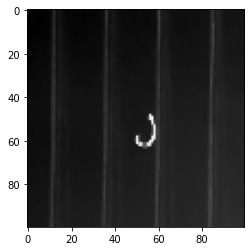

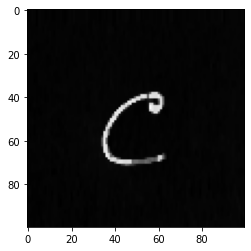

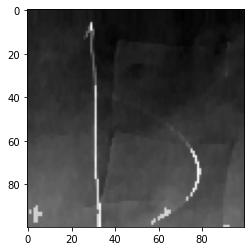

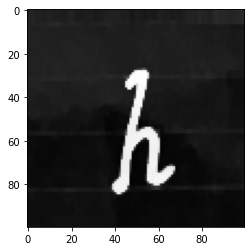

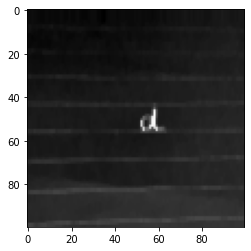

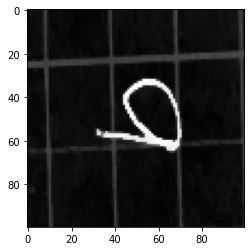

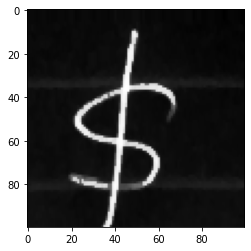

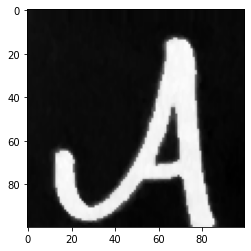

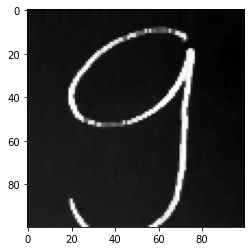

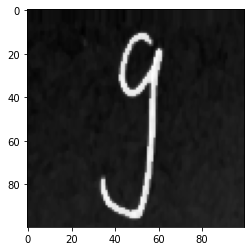

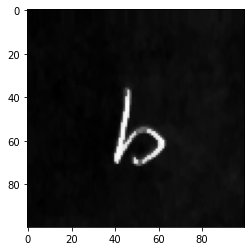

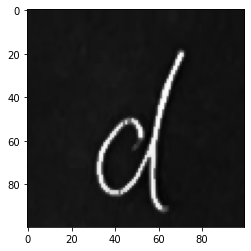

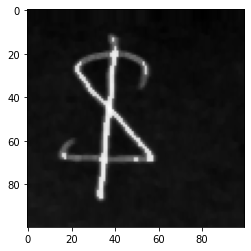

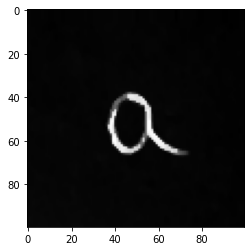

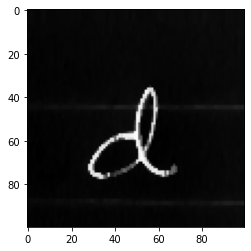

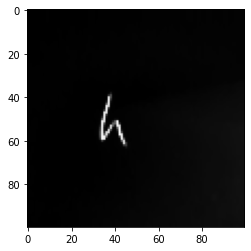

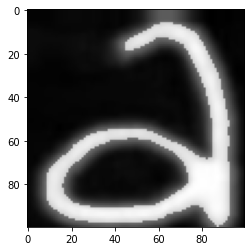

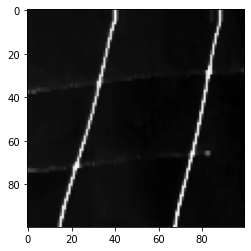

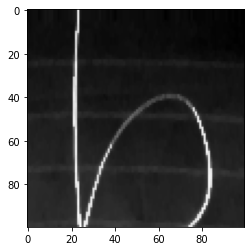

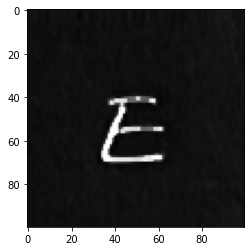

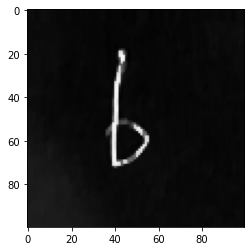

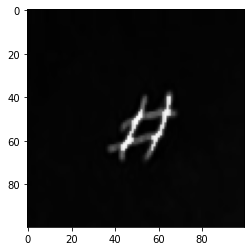

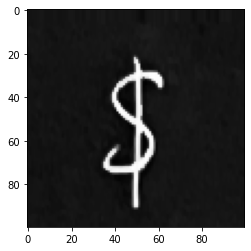

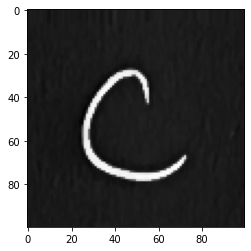

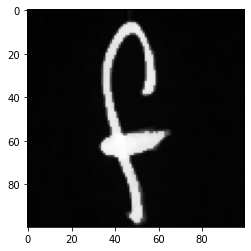

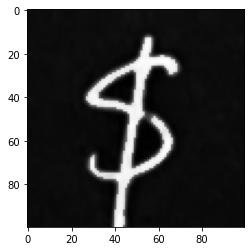

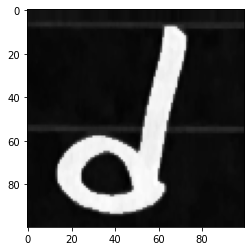

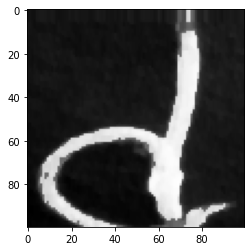

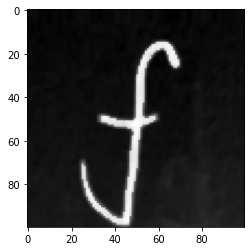

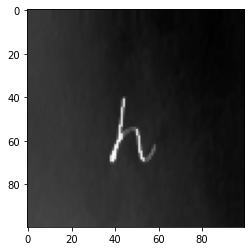

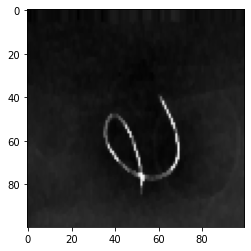

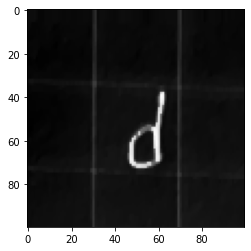

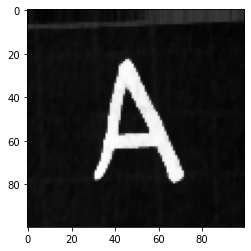

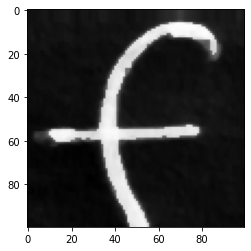

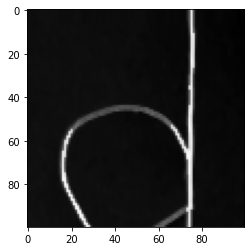

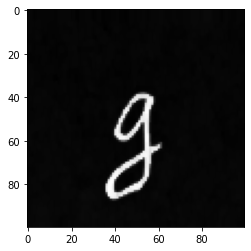

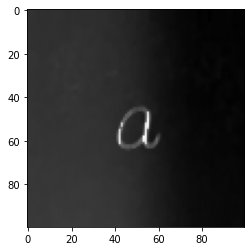

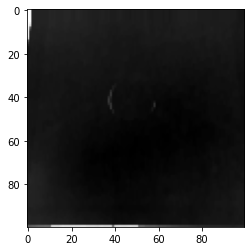

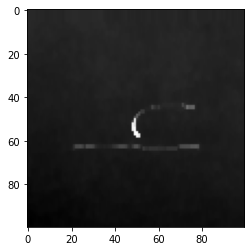

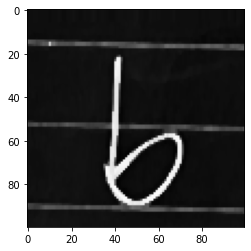

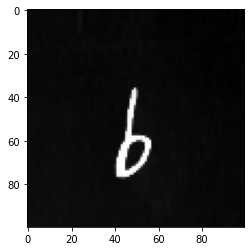

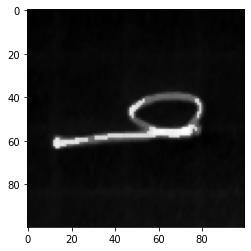

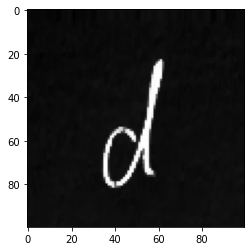

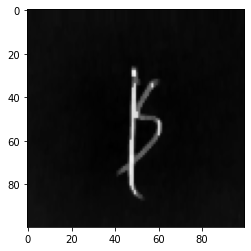

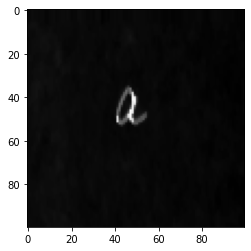

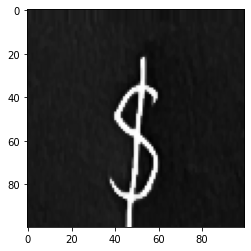

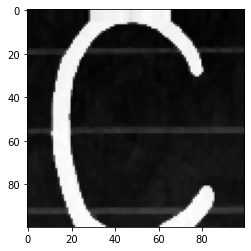

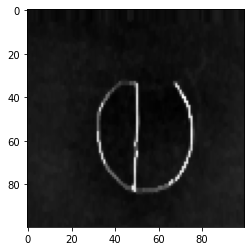

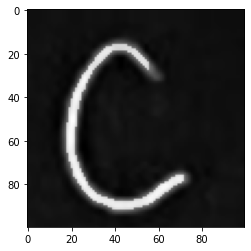

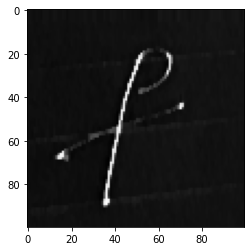

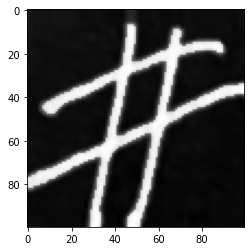

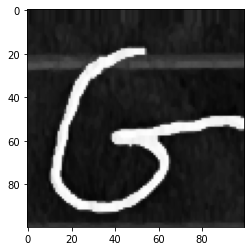

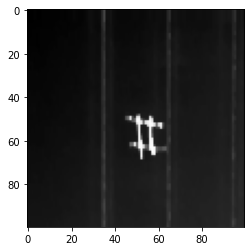

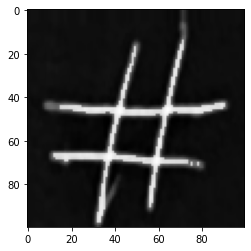

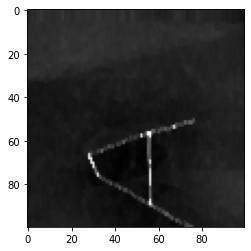

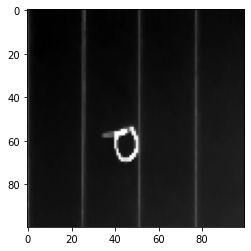

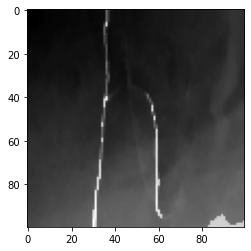

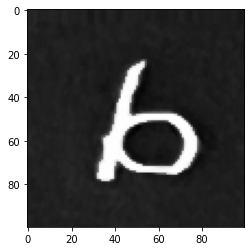

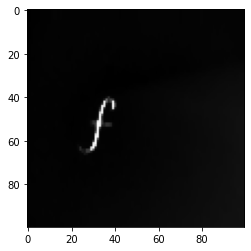

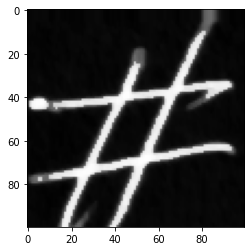

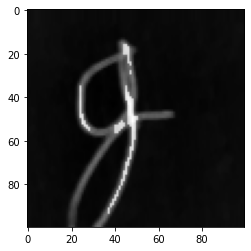

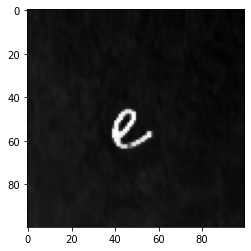

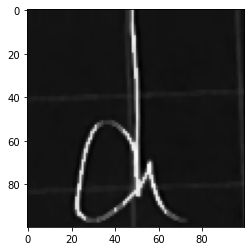

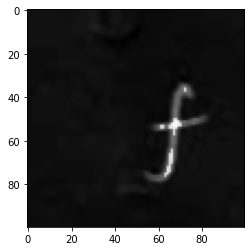

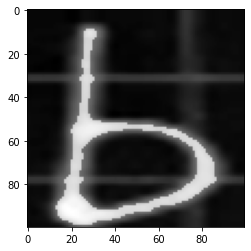

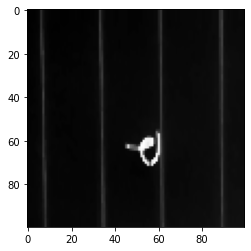

In [992]:
test = data[:,-100:-1]
testp = preprocess(test)
for im in testp:
    show(im)

### Data imports

In [1038]:
data = np.load("data_train.npy")
labels = np.load("labels_train.npy")

In [1039]:
cnn_input, labels_new = augment(preprocess(data), labels)

In [1070]:
cnn_input = cnn_input.reshape(-1,100,100,3)

In [1007]:
# train test split twice to get the splits
# train_x, inter_x, train_y, inter_y = train_test_split(data_rot_augment, labels_augment, train_size=.7)
x_train, x_inter, labels_train, labels_inter = train_test_split(cnn_input, labels_new, train_size=.7)

In [1008]:
x_val, x_test, labels_val, labels_test = train_test_split(x_inter, labels_inter, train_size=.5)

##### Ensuring that data is in the proper format for input into Xception

In [1009]:
x_train = x_train.reshape(-1, 100, 100, 3)
x_val = x_val.reshape(-1, 100, 100, 3)
x_test = x_test.reshape(-1, 100, 100, 3)

In [1010]:
x_train.shape, x_val.shape, x_test.shape

((18816, 100, 100, 3), (4032, 100, 100, 3), (4032, 100, 100, 3))

In [1011]:
labels_train_ohe = OneHotEncoder().fit_transform(labels_train.reshape(-1,1)).toarray()
labels_val_ohe = OneHotEncoder().fit_transform(labels_val.reshape(-1,1)).toarray()
labels_test_ohe = OneHotEncoder().fit_transform(labels_test.reshape(-1,1)).toarray()

In [1012]:
# follow the following format
cnn_dataset = (x_train, labels_train_ohe, x_val, labels_val_ohe, x_test, labels_test_ohe)

### CNN training and architecture

In [966]:
# Let's create a custom callback class
class PerfEvalCustomCallback(keras.callbacks.Callback):
    
    def __init__(self, perf_data):
        self.perf_data = perf_data
    
    # we define the on_epoch_end callback and save the loss and accuracy in perf_data
    def on_epoch_end(self, epoch, logs=None):
        self.perf_data[epoch,0] = logs['loss']
        self.perf_data[epoch,1] = logs['accuracy']
        self.perf_data[epoch,2] = logs['val_loss']
        self.perf_data[epoch,3] = logs['val_accuracy']

    def get_perf_data():
        return self.perf_data

In [967]:
# Plot the model's performance during training (across epochs)
def plot_training_perf(train_loss, train_acc, val_loss, val_acc, fs=(8,5)):
    plt.figure(figsize=fs)


    assert train_loss.shape == val_loss.shape and train_loss.shape == val_acc.shape and val_acc.shape == train_acc.shape
    
    # assume we have one measurement per epoch
    num_epochs = train_loss.shape[0]
    epochs = np.arange(0, num_epochs)
    
    # Can you figure out why this makes sense? Why remove -0.5?
    plt.plot(epochs-0.5, train_loss, 'm', linewidth=2,  label='Loss (Training)')
    plt.plot(epochs-0.5, train_acc, 'r--', linewidth=2, label='Accuracy (Training)')
    
    plt.plot(epochs, val_loss, 'g', linewidth=2, label='Loss (Validation)')
    plt.plot(epochs, val_acc, 'b:', linewidth=2, label='Accuracy (Validation)')
    
    
    plt.xlim([0, num_epochs])
    plt.ylim([0, 1.05])
    
    plt.legend()
    
    plt.show()

In [1019]:
# Customize this function as you like but makes sure it is implemented correctly.    
# Note: If you need to change the method definition to add more arguments, make sure to make 
# the new arguments optional (and have a sensible default value)

from sklearn.metrics import classification_report, balanced_accuracy_score

def evaluate_model(name, model, eval_data, 
                   plot_training=True, evaluate_on_test_set=True):
    
    # unpack the stuff
    perf_data, dataset = eval_data
    train_x, train_y, val_x, val_y, test_x, test_y = dataset
    
    # get predictions from the model
    train_preds = model.predict(train_x)
    val_preds = model.predict(val_x)
    
    # measure the accuracy (as categorical accuracy since we have a softmax layer)
    catacc_metric = keras.metrics.CategoricalAccuracy()
    catacc_metric.update_state(train_y, train_preds)
    train_acc = catacc_metric.result()
    
    catacc_metric = keras.metrics.CategoricalAccuracy()
    catacc_metric.update_state(val_y, val_preds)
    val_acc = catacc_metric.result()
    print('[{}] Training Accuracy: {:.3f}%, Validation Accuracy: {:.3f}%'.format(name, 100*train_acc, 100*val_acc))
    
    if plot_training:
        plot_training_perf(perf_data[:,0], perf_data[:,1], perf_data[:,2], perf_data[:,3])
        
    if evaluate_on_test_set:
        ### Evaluate the model on test data and put the results in 'test_loss', 'test_acc' (set verbose = 0)
        ###* put your code here (~1-2 lines) *###
        
        test_preds = model.predict(test_x)
        
        accuracy_obj = keras.metrics.CategoricalAccuracy()
        accuracy_obj.update_state(test_y, test_preds)
        test_acc = accuracy_obj.result()
        
        test_loss, _ = model.evaluate(test_x, test_y) #the test_acc could also be extracted here where the _ is
        
        cat_loss_obj = tf.keras.losses.CategoricalCrossentropy()
        test_ce_loss = cat_loss_obj(test_y, test_preds)
        
        
        print('[{}]  Test loss: {:.5f}; test accuracy: {:.3f}%'.format(name, test_loss, 100*test_acc))
        print('[{}]  Test cross entropy loss: {:.5f}'.format(name, test_ce_loss))
        
        
    
    # You can add stuff here if you want
    ###* put your code here (0+ lines) *###
    
    
    return 

In [ ]:
evaluate_model("CNN", cnn_model, eval_data)

In [1089]:
base_model = keras.applications.Xception(
weights='imagenet',
input_shape=(100,100,3),
include_top=False)

base_model.trainable=False

In [1090]:
inputs = keras.Input(shape=(100,100,3))
x = base_model.output
x = keras.layers.GlobalAveragePooling2D()(x)
x = keras.layers.Dense(200, activation='relu')(x)
x = keras.layers.Dense(100, activation='relu')(x)
x = keras.layers.Dense(50, activation='relu')(x)
outputs = keras.layers.Dense(10, activation='softmax')(x)
model = keras.Model(inputs=base_model.inputs, outputs=outputs)

In [1091]:
for layer in model.layers:
    layer.trainable = True

In [1092]:
model.compile(loss='categorical_crossentropy', optimizer='nadam', metrics=['accuracy'])

In [1085]:
perf_data = np.zeros((10, 4))
perf_eval_cb = PerfEvalCustomCallback(perf_data)
early_stop_cb = keras.callbacks.EarlyStopping(monitor='loss', mode='min', patience=4)

In [1086]:
model.summary()

Model: "model_8"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_30 (InputLayer)          [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 49, 49, 32)   864         ['input_30[0][0]']               
                                                                                                  
 block1_conv1_bn (BatchNormaliz  (None, 49, 49, 32)  128         ['block1_conv1[0][0]']           
 ation)                                                                                           
                                                                                            

 n)                                                                                               
                                                                                                  
 block4_sepconv2 (SeparableConv  (None, 12, 12, 728)  536536     ['block4_sepconv2_act[0][0]']    
 2D)                                                                                              
                                                                                                  
 block4_sepconv2_bn (BatchNorma  (None, 12, 12, 728)  2912       ['block4_sepconv2[0][0]']        
 lization)                                                                                        
                                                                                                  
 conv2d_18 (Conv2D)             (None, 6, 6, 728)    186368      ['add_49[0][0]']                 
                                                                                                  
 block4_po

                                                                                                  
 block7_sepconv1_bn (BatchNorma  (None, 6, 6, 728)   2912        ['block7_sepconv1[0][0]']        
 lization)                                                                                        
                                                                                                  
 block7_sepconv2_act (Activatio  (None, 6, 6, 728)   0           ['block7_sepconv1_bn[0][0]']     
 n)                                                                                               
                                                                                                  
 block7_sepconv2 (SeparableConv  (None, 6, 6, 728)   536536      ['block7_sepconv2_act[0][0]']    
 2D)                                                                                              
                                                                                                  
 block7_se

                                                                  'add_54[0][0]']                 
                                                                                                  
 block10_sepconv1_act (Activati  (None, 6, 6, 728)   0           ['add_55[0][0]']                 
 on)                                                                                              
                                                                                                  
 block10_sepconv1 (SeparableCon  (None, 6, 6, 728)   536536      ['block10_sepconv1_act[0][0]']   
 v2D)                                                                                             
                                                                                                  
 block10_sepconv1_bn (BatchNorm  (None, 6, 6, 728)   2912        ['block10_sepconv1[0][0]']       
 alization)                                                                                       
          

 block12_sepconv3 (SeparableCon  (None, 6, 6, 728)   536536      ['block12_sepconv3_act[0][0]']   
 v2D)                                                                                             
                                                                                                  
 block12_sepconv3_bn (BatchNorm  (None, 6, 6, 728)   2912        ['block12_sepconv3[0][0]']       
 alization)                                                                                       
                                                                                                  
 add_58 (Add)                   (None, 6, 6, 728)    0           ['block12_sepconv3_bn[0][0]',    
                                                                  'add_57[0][0]']                 
                                                                                                  
 block13_sepconv1_act (Activati  (None, 6, 6, 728)   0           ['add_58[0][0]']                 
 on)      

In [1066]:
hobj = model.fit(x_train, labels_train_ohe, validation_data=(x_val, labels_val_ohe), epochs=10, batch_size=50,
         shuffle=True, callbacks=[perf_eval_cb, early_stop_cb], verbose=1)

Epoch 1/10
377/377 [==============================] - 791s 2s/step - loss: 0.9091 - accuracy: 0.7068 - val_loss: 1.6019 - val_accuracy: 0.6823
Epoch 2/10
377/377 [==============================] - 765s 2s/step - loss: 0.3833 - accuracy: 0.8868 - val_loss: 0.6148 - val_accuracy: 0.8199
Epoch 3/10
377/377 [==============================] - 778s 2s/step - loss: 0.2659 - accuracy: 0.9196 - val_loss: 0.7714 - val_accuracy: 0.8643
Epoch 4/10
377/377 [==============================] - 783s 2s/step - loss: 0.2030 - accuracy: 0.9395 - val_loss: 0.7210 - val_accuracy: 0.8584
Epoch 5/10
377/377 [==============================] - 811s 2s/step - loss: 0.1621 - accuracy: 0.9504 - val_loss: 0.4860 - val_accuracy: 0.8663
Epoch 6/10
377/377 [==============================] - 799s 2s/step - loss: 0.1367 - accuracy: 0.9581 - val_loss: 0.3396 - val_accuracy: 0.9008
Epoch 7/10
377/377 [==============================] - 785s 2s/step - loss: 0.1059 - accuracy: 0.9688 - val_loss: 0.3019 - val_accuracy: 0.9194

NameError: name 'dataset' is not defined

In [1067]:
eff_epochs = len(hobj.history['loss'])
eval_data = (perf_data[0:eff_epochs,:], cnn_dataset)

[test] Training Accuracy: 97.784%, Validation Accuracy: 93.824%


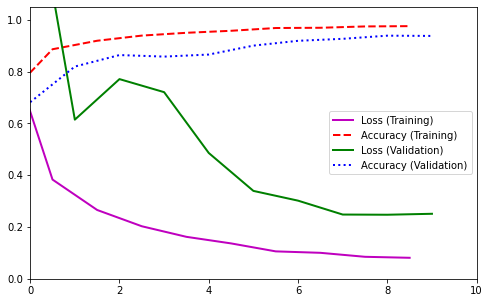

126/126 [==============================] - 42s 242ms/step - loss: 0.2857 - accuracy: 0.9335
[test]  Test loss: 0.28567; test accuracy: 93.353%
[test]  Test cross entropy loss: 0.28447


In [1068]:
evaluate_model("test", model, eval_data)

# FULL TRAINING

In [1071]:
cnn_input.shape

(26880, 100, 100, 3)

In [1077]:
labels_new_ohe = OneHotEncoder().fit_transform(labels_new.reshape(-1,1)).toarray()

In [1078]:
labels_new_ohe.shape

(26880, 10)

In [1095]:
hobj = model.fit(cnn_input, labels_new_ohe, epochs=8, batch_size=100,
         shuffle=True, verbose=1)

Epoch 1/8
269/269 [==============================] - 967s 4s/step - loss: 0.2659 - accuracy: 0.9217
Epoch 2/8
269/269 [==============================] - 960s 4s/step - loss: 0.1679 - accuracy: 0.9480
Epoch 3/8
269/269 [==============================] - 975s 4s/step - loss: 0.1285 - accuracy: 0.9607
Epoch 4/8
269/269 [==============================] - 964s 4s/step - loss: 0.0978 - accuracy: 0.9718
Epoch 5/8
269/269 [==============================] - 1004s 4s/step - loss: 0.0806 - accuracy: 0.9766
Epoch 6/8
  1/269 [..............................] - ETA: 16:14 - loss: 0.0712 - accuracy: 0.9600

KeyboardInterrupt: 

In [1096]:
model.save('final_trained_model')

INFO:tensorflow:Assets written to: final_trained_model\assets


# TEST SECTION

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow.keras as keras
import cv2
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
import time

In [ ]:
test_data = np.load("put_path_here.npy")
test_labels = np.load("put_path_here.npy")

weights = "final_trained_model"
model = keras.models.load_model(weights)

### Functions used to preprocess data

In [ ]:
def show(im):
    plt.imshow(im, cmap='gray')
    plt.show()

def invert(im):
    return (im*-1)+255

def min_max_scale(im):
    im = MinMaxScaler().fit_transform(im.ravel().reshape(-1,1))
    return im.reshape(300,300)

def brighten(im):
    m = np.max(im)-.3
    im[im >= m] += 0.3
    im[im < m] -= 0.3
    return im

def blur(im, kernel):
    im = im.astype("uint8")
    im = cv2.medianBlur(im, kernel)
    return im

def morph_close(im, kernel, i):
    return cv2.morphologyEx(im, cv2.MORPH_CLOSE, kernel, iterations=i)

def morph_open(im, kernel, i):
    return cv2.morphologyEx(im, cv2.MORPH_OPEN, kernel, iterations=i)

def morph_dilate(im, kernel, i):
    return cv2.dilate(im, kernel, iterations=i)

def morph_erode(im, kernel, i):
    return cv2.erode(im, kernel, iterations=i)

def transform(im):
    dest = np.float32([[0,0],[300,0],[0,300],[300,300]])
    source = np.float32([[25,25],[275,25],[25,275],[275,275]])
    res = cv2.getPerspectiveTransform(source,dest)
    return cv2.warpPerspective(im, res, (300,300))

def preprocess(ims):
    r = []
    for im in ims.T:
        im = im.reshape((300,300))
        im = transform(im)
        im = invert(im)
        im = blur(im, 5)
        im = morph_erode(im, (3,3), 5)
        im = morph_dilate(im, (3,3), 5)
        im = morph_close(im, (3,3), 5)
        im = morph_open(im, (3,3), 5)
        im = min_max_scale(im)
        im = brighten(im)
        im = min_max_scale(im)
        im = cv2.resize(im, (100,100))
        im = np.stack((im,)*3, axis=-1)
        r.append(im)
    return np.array(r)

In [ ]:
test_data = preprocess(test_data)
test_labels_ohe = OneHotEncoder().fit_transform(test_labels.reshape(-1,1)).toarray()

In [ ]:
model = keras.models.load_model("put_model_file_here")

In [ ]:
test_preds = model.predict(test_data)
        
accuracy_obj = keras.metrics.CategoricalAccuracy()
accuracy_obj.update_state(test_labels_ohe, test_preds)
test_acc = accuracy_obj.result()

test_loss, _ = model.evaluate(test_data, test_labels_ohe)

cat_loss_obj = tf.keras.losses.CategoricalCrossentropy()
test_ce_loss = cat_loss_obj(test_labels_ohe, test_preds)


print('[{}]  Test loss: {:.5f}; test accuracy: {:.3f}%'.format(name, test_loss, 100*test_acc))
print('[{}]  Test cross entropy loss: {:.5f}'.format(name, test_ce_loss))